# Initialisation du projet

In [1]:
# bibliotheques mathematiques
import numpy as np

# bibliotheques pour les representations graphiques
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats

# bibliotheques pour le machine learning
import sklearn.decomposition
import sklearn.svm
import sklearn.neighbors
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# bibliotheque pour les modèles
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier

# bibliotheques pour le chargement des donnees
import csv
import pandas as pd

plt.ion()

In [2]:
def load_sub_sets(ratio_train, ratio_valid, train_csv, test_csv):
    data_train = np.genfromtxt(train_csv, delimiter=',', skip_header=1) # lecture du fichier train_csv
    y = data_train[:,0]                                                 # les labels
    X = data_train[:,1:]                                                # les donnees (sans leurs labels)
    
    Ntot   = X.shape[0]                                                 # nombre d'images dans les donnees X
    Ntrain = int(ratio_train*Ntot)                                      # nombre d'images pour l'entrainement
    Nvalid = int(ratio_valid*Ntot)                                      # nombre d'images pour la validation
    
    X_train = X[0: Ntrain].copy()                                       # les donnees qu'on utilise pour entrainer les modeles
    y_train = y[0: Ntrain].copy()                                       # les labels associes 
    
    X_valid = X[Ntrain:Ntrain+Nvalid].copy()                            # les donnees qu'on utilise pour tester les modeles
    y_valid = y[Ntrain:Ntrain+Nvalid].copy()                            # les labels associes
        
    data_test = np.genfromtxt(test_csv, delimiter=',', skip_header=1)   # lecture du fichier test_csv
    data_test = data_test[1:]                                           # donnees generales du fichier test_csv (celles que le modele ne connait pas)
    X_test  = data_test[:,1:]                                           # les labels
    y_test  = data_test[:,0]                                            # les donnees (sans leur label)
    
    return X, y, X_train, y_train, X_valid, y_valid, X_test, y_test

In [3]:
dim_repre = 28
ratio_train = 0.7
ratio_valid = 0.3

X, y, X_train, y_train, X_valid, y_valid, X_test, y_test = load_sub_sets(ratio_train, ratio_valid, 'sign_mnist_train.csv', 'sign_mnist_test.csv')

---
# Exploration des données

On affiche quelques données du dataset sous la forme d'images

In [4]:
nb_alphabet_letters = 26

def get_letter_at_idx(idx):
    return chr(ord('A') + idx)

## 1. Représentation de différentes données

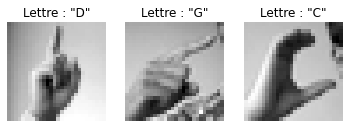

In [5]:
nb_displayed_dataset = 3
fig, ax = plt.subplots(1, nb_displayed_dataset)                         # creation de 3 subplots horizontaux

for i in range(nb_displayed_dataset):
    label_idx = int(y[i])                                               # on récupère l'indice alphabetique lié à la donnée
    letter_rep = chr(ord('A') + label_idx)                              # on transforme l'indice en lettre (eg. indice 0 devient 'A')
    ax[i].set_axis_off()                                                # on cache les axes
    ax[i].set_title(f'Lettre : "{letter_rep}"')                         # on affiche la lettre dans le titre
    ax[i].imshow(X[i].reshape(dim_repre, dim_repre), cm.gray)           # on affiche l'image sous la forme de nuance de gris en
                                                                        #  transformant la matrice linéaire en matrice carré

## 2. Différentes représentations d'un même label

In [6]:
selected_label_idx = 0                                                  # on choisi d'afficher différentes représentations d'une lettre
selected_letter = chr(ord('A') + selected_label_idx)                    # la lettre selectionnée
only_A = (selected_label_idx == y)                                      # on créé un mask qui filtre les données qui représente notre lettre sélectionnée
X_of_A = X[only_A]                                                      # on applique notre masque
print(f'Nous avons trouvés {X_of_A.shape[0]} représentations de la lettre {selected_letter}.')

Nous avons trouvés 1126 représentations de la lettre A.


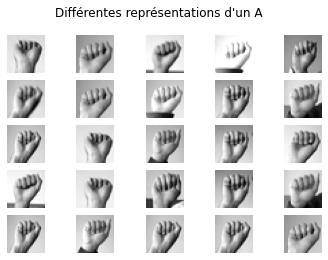

In [7]:
nb_subplots_by_ax = 5
fig, ax = plt.subplots(nb_subplots_by_ax, nb_subplots_by_ax)            # creation des subplots

fig.suptitle(f'Différentes représentations d\'un {selected_letter}')
for i in range(nb_subplots_by_ax):
    for j in range(nb_subplots_by_ax):
        idx = i*nb_subplots_by_ax + j                                   # on transforme le couple (i,j) en l'indice de l'image
        img = X_of_A[idx].reshape(dim_repre, dim_repre)                 # transformation de la matrice linéaire en matrice carré
        ax[i,j].set_axis_off()                                          # on cache les axes
        ax[i,j].imshow(img, cm.gray)                                    # on affiche l'image sous la forme de nuance de gris

## 3. Analyse du dataset

In [8]:
print("Description des données :")

df = pd.DataFrame(X)
df.describe()

Description des données :


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,165.533673,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,31.279244,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,148.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,167.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,186.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [9]:
print("Description des labels :")

df = pd.DataFrame(y, columns=["labels"])
df.describe()

Description des labels :


,labels
count,27455.000000
mean,12.318813
std,7.287552
min,0.000000
25%,6.000000
50%,13.000000
75%,19.000000
max,24.000000


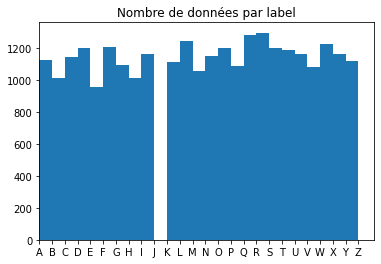


Il manque les lettres : J, Z


In [10]:
xticks_labels = [get_letter_at_idx(i) for i in range(nb_alphabet_letters)]

fig, ax = plt.subplots(1, 1)
hist, _, _ = ax.hist(y, bins=range(nb_alphabet_letters))
ax.set_xticks(range(nb_alphabet_letters))
ax.set_title('Nombre de données par label')
ax.set_xticklabels(xticks_labels)
ax.set_xlim(0)
plt.show()

h = hist.copy()
h.resize(nb_alphabet_letters)
missing_indexes = [arg[0] for arg in np.argwhere(h == 0.)]
print(f"\nIl manque les lettres : {', '.join(map(get_letter_at_idx, missing_indexes))}")

## 4. Affichage des images moyennes

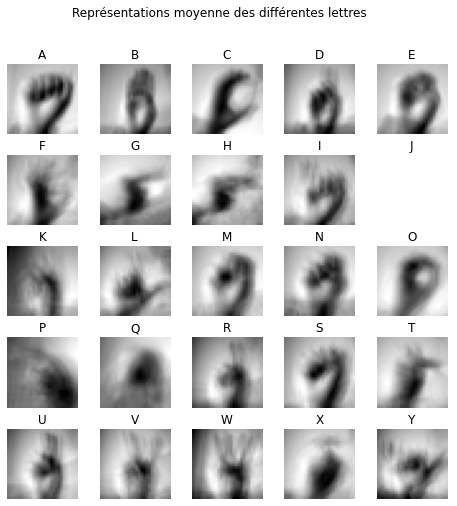

In [11]:
nb_rows = 5
nb_cols = 5
fig, ax = plt.subplots(nb_rows, nb_cols, figsize=(8,8))                         # creation de 3 subplots horizontaux

fig.subplots_adjust(hspace=.3)
fig.suptitle(f"Représentations moyenne des différentes lettres")

for i in range(nb_rows):
    for j in range(nb_cols):
        idx = i * nb_rows + j
        if idx > nb_alphabet_letters:
            break
        ax[i,j].set_axis_off()
        ax[i,j].set_title(get_letter_at_idx(idx))                         # on affiche la 
        if idx in missing_indexes:
            continue
        only_of_letter = (idx == y)                                      # on créé un mask qui filtre les données qui représente notre lettre sélectionnée
        X_of_letter = X[only_of_letter]                                                      # on applique notre masque
        mean_X_of_letter = np.mean(X_of_letter, axis=0)
        mean_img = mean_X_of_letter.reshape((dim_repre, dim_repre))
        ax[i,j].imshow(mean_img, cm.gray)

# Filtrage des doublons

In [12]:
def show_duplicated(data, duplicated, n_rows=3, n_max_cols=5):
    fig, ax = plt.subplots(n_rows, n_max_cols+1)

    fig.suptitle("Affichage des images dupliqués")
    duplicated = list(filter(lambda x: len(x[1]) == n_max_cols, duplicated))

    for i, (img_idx, others) in enumerate(duplicated[:n_rows]):
        img = data[img_idx]
        ax[i, 0].imshow(img.reshape(dim_repre, dim_repre), cm.gray)
        ax[i, 0].set_axis_off()                                                # on cache les axes
        if i == 0: ax[i, 0].set_title("originale")                         # on affiche la lettre dans le titre
        for j, dup_img_idx in enumerate(others):
            dup_img = data[dup_img_idx]
            ax[i, j+1].imshow(dup_img.reshape(dim_repre, dim_repre), cm.gray)
            ax[i, j+1].set_axis_off()                                                # on cache les axes
            if i == 0: ax[i, j+1].set_title(f"{j+1}")                         # on affiche la lettre dans le titre

# from @abakar https://stackoverflow.com/a/60223949
def remove_values_with_corr_sup(data, corr_bound):
    def get_duplicated_data(corr_upper, col):
        mask = (corr_upper[col] > corr_bound).to_numpy()
        return [args[0] for args in np.argwhere(mask == True)]
    df = pd.DataFrame(data).transpose()
    corr_matrix = df.corr().abs()
    triu_ones = np.triu(np.ones(corr_matrix.shape), k=1)
    corr_upper = corr_matrix.where(triu_ones.astype(np.bool))
    to_drop = [col for col in corr_upper.columns if any(corr_upper[col] > corr_bound)]
    duplicated = [(col, get_duplicated_data(corr_upper, col)) for col in to_drop]
    df = df.drop(df[to_drop], axis=1)
    data = df.transpose().to_numpy()
    return data, duplicated, to_drop

In [13]:
corr_threshold = .99

print("Suppression des doublons dans les données de validation ...")
X_valid_bis, X_valid_dup, X_valid_dropped = remove_values_with_corr_sup(X_valid, corr_threshold)
y_valid_bis = np.delete(y_valid, X_valid_dropped)
print("Suppression des doublons dans les données de test ...")
X_test_bis, X_test_dup, X_test_dropped = remove_values_with_corr_sup(X_test, corr_threshold)
y_test_bis = np.delete(y_test, X_test_dropped)

Suppression des doublons dans les données de validation ...
Suppression des doublons dans les données de test ...


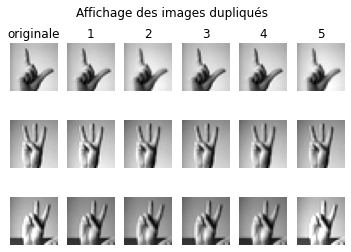

In [14]:
show_duplicated(X_valid, X_valid_dup)

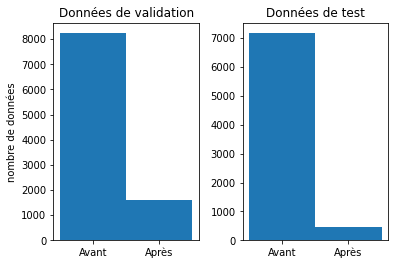

In [15]:
fig, ax = plt.subplots(1, 2)

fig.subplots_adjust(wspace=.3)

ax[0].set_title("Données de validation")
ax[0].bar(["Avant", "Après"], [X_valid.shape[0], X_valid_bis.shape[0]], width=1)
ax[0].set_ylabel("nombre de données")

ax[1].set_title("Données de test")
ax[1].bar(["Avant", "Après"], [X_test.shape[0], X_test_bis.shape[0]], width=1)

plt.show()

---

# Préprocessing
Sélection du meilleur nombre de composants

In [16]:
class CompRanker:
    def __init__(self, n):
        self.n_comps_score = [0 for i in range(n)]
        
    def update_rank(self, data, reverse=False):
        for i, x in enumerate(data):
            self.n_comps_score[i] += -x if reverse else x

    def get_best_n_comps(self, nb_comp_range):
        scores = sorted(enumerate(self.n_comps_score), key=lambda x: x[1], reverse=True)
        formated_ranks = [(nb_comp_range[i], score) for i, score in scores]
        return tuple(zip(*formated_ranks))

In [28]:
def get_scores_for_nb_comp_range(nb_comp_range):
    training_scores = []                                                # tableau des scores d'entrainement en fonction du nombre de composants séléctionné
    valid_scores = []                                                   # tableau des scores de validation en fonction du nombre de composants séléctionné
    explained_variances = []                                                   # tableau des scores de validation en fonction du nombre de composants séléctionné
    tab_result = pd.DataFrame(columns=[
        'score d\'entrainement',
        'score de validation',
        'différence'])                                                  # tableau récapitulatif

    for nb_comp in nb_comp_range:
        print(f'Récupération du score pour une PCA de {nb_comp} composants...')
        pre_proc = sklearn.decomposition.PCA(n_components=nb_comp)      # création d'un PCA permettant la compression des images en nb_comp pixels
        pre_proc.fit(X)                                                 # entrainement du modèle PCA
        X_train_transformed = pre_proc.transform(X_train)               # transformation des données d'entrainement en fonction du PCA
        X_valid_transformed = pre_proc.transform(X_valid)               # transformation des données de validation en fonction du PCA

        clf = sklearn.svm.SVC(kernel='poly', coef0=1, degree=2)         # on choisit un classifieur SVC
        clf.fit(X_train_transformed, y_train)                           # on entraine notre classifieur avec X_train_transformed

        train_score = clf.score(X_train_transformed, y_train)           # on récupère les scores liés (entrainement)
        valid_score = clf.score(X_valid_transformed, y_valid)           # on récupère les scores liés (validation)

        tab_result.loc[f'{nb_comp} composants'] = np.array([
            f'{train_score * 100:.2f}%',
            f'{valid_score * 100:.2f}%',
            f'{(train_score-valid_score) * 100:.2f}%'])                 # ajout des données dans le tableau récapitulatif (en pourcentage)

        training_scores.append(train_score * 100)                       # on sauvegarde les scores d'entrainement pour les statistiques
        valid_scores.append(valid_score * 100)                          # on sauvegarde les scores de validation pour les statistiques
        explained_variances.append(sum(pre_proc.explained_variance_ratio_) * 100)

    return np.array(training_scores), np.array(valid_scores), explained_variances, tab_result

In [29]:
def plot_best_explained_variance(comp_ranker, nb_comp_range, explained_variances):
    plt.title('Évolution de la variance expliquée\nen fonction du nombre de composants')
    plt.plot(nb_comp_range, explained_variances)
    plt.xlabel('nombre de composants')
    plt.ylabel('variance expliquée (%)')

    best_index = np.argmax(explained_variances)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, explained_variances[best_index], marker='X', color='red')

    print(f'Meilleur nombre de composants pour maximiser la variance expliqué : {best_n_comp}\n')
    comp_ranker.update_rank(explained_variances)

In [30]:
def plot_best_scores(comp_ranker, nb_comp_range, training_scores, valid_scores):
    plt.title('Évolution du score en fonction du nombre de composants')
    plt.plot(nb_comp_range, training_scores, label='train score')
    plt.plot(nb_comp_range, valid_scores, label='valid score')
    plt.xlabel('nombre de composants')
    plt.ylabel('scores (%)')
    plt.legend()

    best_index = np.argmax(training_scores)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, training_scores[best_index], marker='X', color='red')

    print(f'Meilleur nombre de composants pour maximiser le score : {best_n_comp}\n')
    comp_ranker.update_rank(training_scores)

In [31]:
def plot_less_overfitting(comp_ranker, nb_comp_range, training_scores, valid_scores):
    diff_scores = training_scores - valid_scores

    plt.title("Évolution de l'overfitting en fonction du nombre de composants")
    plt.plot(nb_comp_range, diff_scores)
    plt.xlabel("nombre de composants")
    plt.ylabel("différence (%)")

    best_index = np.argmin(diff_scores)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, diff_scores[best_index], marker="X", color="red")

    print(f"Meilleur nombre de composants pour minimiser l'overfitting : {best_n_comp}\n")

    comp_ranker.update_rank(diff_scores, reverse=True)

In [32]:
def plot_best_incr_scores(comp_ranker, nb_comp_range, training_scores, valid_scores):
    training_scores_incr = np.array([
        score - training_scores[i-1] if i != 0 else 0
        for i, score in enumerate(training_scores)])
    valid_scores_incr = np.array([
        score - valid_scores[i-1] if i != 0 else 0
        for i, score in enumerate(valid_scores)])

    plt.title("Évolution de l\"accroissement du score en fonction du nombre de composants")
    plt.plot(nb_comp_range, training_scores_incr, label="train score")
    plt.plot(nb_comp_range, valid_scores_incr, label="valid score")
    plt.xlabel("nombre de composants")
    plt.ylabel("accroissement du score (%)")
    plt.legend()

    best_index = np.argmax(training_scores_incr)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, training_scores_incr[best_index], marker="X", color="red")

    print(f"Meilleur nombre de composants pour maximiser le gain de score : {best_n_comp}\n")

    comp_ranker.update_rank(valid_scores_incr)

In [33]:
def get_best_np_comp(comp_ranker, nb_comp_range):
    x_nb_comp, y_score = comp_ranker.get_best_n_comps(nb_comp_range)

    plt.title("Évaluation du meilleur nombre de composants\nen fonction du score moyen")
    plt.bar(x_nb_comp, y_score, width=1)
    plt.xlabel("nombre de composants")
    plt.ylabel("score moyen")

    best_nb_comp, best_score = -1, -1
    for nb_comp, score in zip(x_nb_comp, y_score):
        if score > best_score:
            best_nb_comp = nb_comp
            best_score = score

    plt.plot(best_nb_comp, best_score, marker="X", color="red")
    print(f"Meilleur nombre de composants : {best_nb_comp}\n")

    return best_nb_comp    

## 1. Première sélection (sélection large)

In [34]:
s1_nb_steps = 5
s1_incr = 10
s1_min = 1
s1_max = s1_min + s1_nb_steps * s1_incr
s1_nb_comp_range = np.arange(s1_min, s1_max, s1_incr)

In [35]:
s1_training_scores, s1_valid_scores, s1_explained_variances, s1_tab = get_scores_for_nb_comp_range(s1_nb_comp_range)

Récupération du score pour une PCA de 1 composants...
Récupération du score pour une PCA de 11 composants...
Récupération du score pour une PCA de 21 composants...
Récupération du score pour une PCA de 31 composants...
Récupération du score pour une PCA de 41 composants...


In [36]:
s1_n = len(s1_training_scores)
s1_comp_ranker = CompRanker(s1_n)
s1_tab

,score d'entrainement,score de validation,différence
1 composants,6.97%,6.88%,0.08%
11 composants,84.28%,83.39%,0.89%
21 composants,97.96%,97.81%,0.15%
31 composants,99.22%,99.11%,0.11%
41 composants,99.89%,99.88%,0.01%


Meilleur nombre de composants pour maximiser la variance expliqué : 41



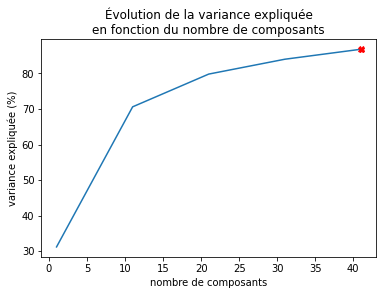

In [60]:
plot_best_explained_variance(s1_comp_ranker, s1_nb_comp_range, s1_explained_variances)

Meilleur nombre de composants pour maximiser le score : 41



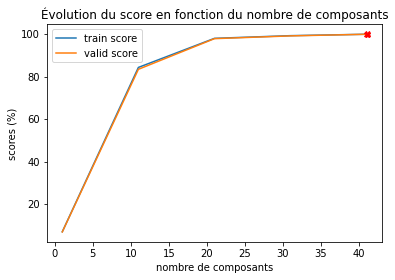

In [38]:
plot_best_scores(s1_comp_ranker, s1_nb_comp_range, s1_training_scores, s1_valid_scores)

Meilleur nombre de composants pour minimiser l'overfitting : 41



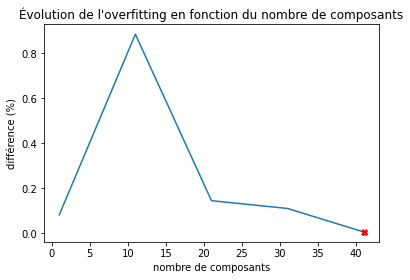

In [39]:
plot_less_overfitting(s1_comp_ranker, s1_nb_comp_range, s1_training_scores, s1_valid_scores)

Meilleur nombre de composants pour maximiser le gain de score : 11



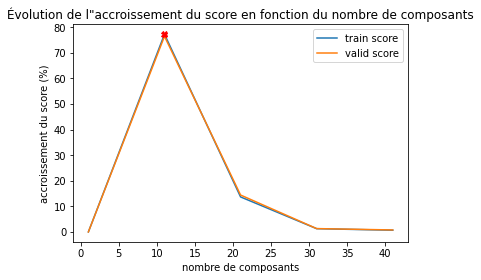

In [40]:
plot_best_incr_scores(s1_comp_ranker, s1_nb_comp_range, s1_training_scores, s1_valid_scores)

Meilleur nombre de composants : 11



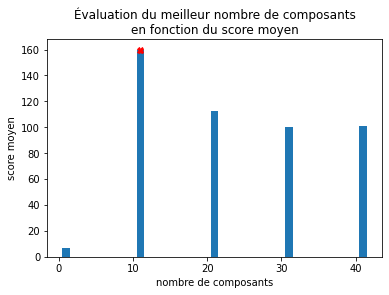

In [41]:
s1_best_nb_comp = get_best_np_comp(s1_comp_ranker, s1_nb_comp_range)

## 2. Deuxième sélection (sélection moyenne)

In [42]:
s2_nb_steps = 5
s2_incr = 3
s2_min = s1_best_nb_comp - int(s2_nb_steps/2)     * s2_incr
s2_max = s1_best_nb_comp + (1+int(s2_nb_steps/2)) * s2_incr
s2_nb_comp_range = np.arange(s2_min, s2_max, s2_incr)

In [43]:
s2_training_scores, s2_valid_scores, s2_explained_variances, s2_tab = get_scores_for_nb_comp_range(s2_nb_comp_range)

Récupération du score pour une PCA de 5 composants...
Récupération du score pour une PCA de 8 composants...
Récupération du score pour une PCA de 11 composants...
Récupération du score pour une PCA de 14 composants...
Récupération du score pour une PCA de 17 composants...


In [44]:
s2_n = len(s2_training_scores)
s2_comp_ranker = CompRanker(s2_n)
s2_tab

,score d'entrainement,score de validation,différence
5 composants,38.05%,37.01%,1.04%
8 composants,69.38%,67.88%,1.50%
11 composants,84.26%,83.39%,0.87%
14 composants,91.94%,91.77%,0.17%
17 composants,95.89%,95.99%,-0.10%


Meilleur nombre de composants pour maximiser la variance expliqué : 17



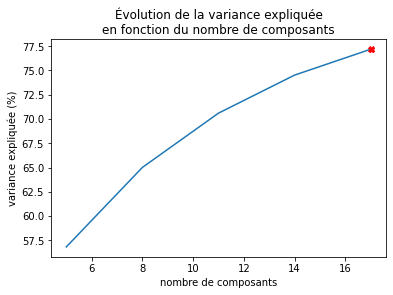

In [45]:
plot_best_explained_variance(s2_comp_ranker, s2_nb_comp_range, s2_explained_variances)

Meilleur nombre de composants pour maximiser le score : 17



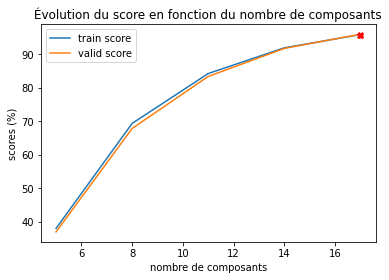

In [46]:
plot_best_scores(s2_comp_ranker, s2_nb_comp_range, s2_training_scores, s2_valid_scores)

Meilleur nombre de composants pour minimiser l'overfitting : 17



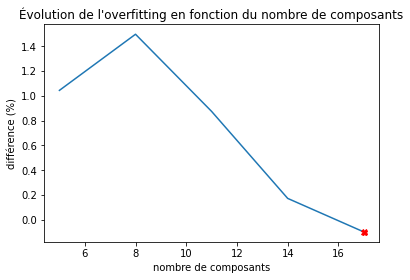

In [47]:
plot_less_overfitting(s2_comp_ranker, s2_nb_comp_range, s2_training_scores, s2_valid_scores)

Meilleur nombre de composants pour maximiser le gain de score : 8



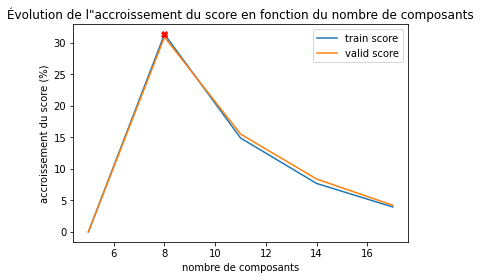

In [48]:
plot_best_incr_scores(s2_comp_ranker, s2_nb_comp_range, s2_training_scores, s2_valid_scores)

Meilleur nombre de composants : 17



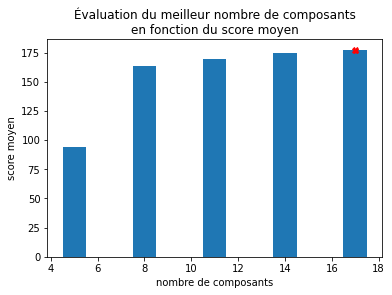

In [49]:
s2_best_nb_comp = get_best_np_comp(s2_comp_ranker, s2_nb_comp_range)

## 3. Troisième sélection (sélection étroite)

In [50]:
s3_nb_steps = 5
s3_incr = 1
s3_min = s2_best_nb_comp - int(s3_nb_steps/2)     * s3_incr
s3_max = s2_best_nb_comp + (1+int(s3_nb_steps/2)) * s3_incr
s3_nb_comp_range = np.arange(s3_min, s3_max, s3_incr)

In [51]:
s3_training_scores, s3_valid_scores, s3_explained_variances, s3_tab = get_scores_for_nb_comp_range(s3_nb_comp_range)

Récupération du score pour une PCA de 15 composants...
Récupération du score pour une PCA de 16 composants...
Récupération du score pour une PCA de 17 composants...
Récupération du score pour une PCA de 18 composants...
Récupération du score pour une PCA de 19 composants...


In [52]:
s3_n = len(s3_training_scores)
s3_comp_ranker = CompRanker(s3_n)
s3_tab

,score d'entrainement,score de validation,différence
15 composants,94.04%,93.78%,0.26%
16 composants,95.24%,95.03%,0.20%
17 composants,95.92%,95.99%,-0.07%
18 composants,96.28%,96.36%,-0.08%
19 composants,96.82%,96.86%,-0.03%


Meilleur nombre de composants pour maximiser la variance expliqué : 19



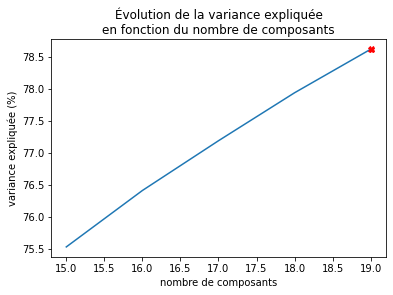

In [53]:
plot_best_explained_variance(s3_comp_ranker, s3_nb_comp_range, s3_explained_variances)

Meilleur nombre de composants pour maximiser le score : 19



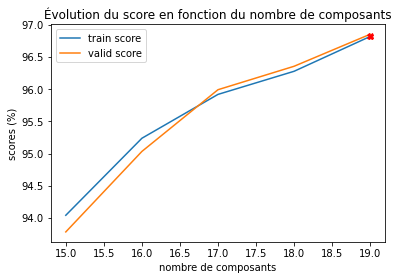

In [54]:
plot_best_scores(s3_comp_ranker, s3_nb_comp_range, s3_training_scores, s3_valid_scores)

Meilleur nombre de composants pour minimiser l'overfitting : 18



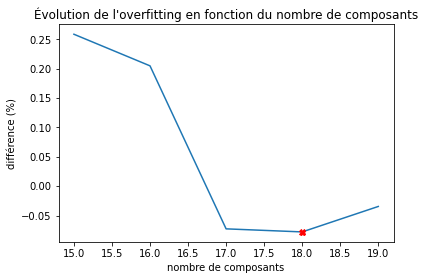

In [55]:
plot_less_overfitting(s3_comp_ranker, s3_nb_comp_range, s3_training_scores, s3_valid_scores)

Meilleur nombre de composants pour maximiser le gain de score : 16



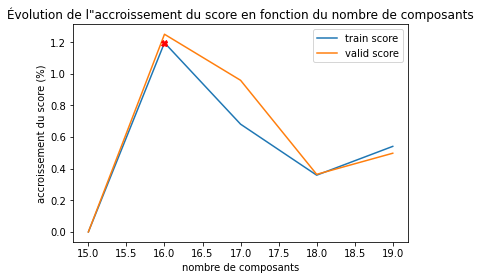

In [56]:
plot_best_incr_scores(s3_comp_ranker, s3_nb_comp_range, s3_training_scores, s3_valid_scores)

Meilleur nombre de composants : 19



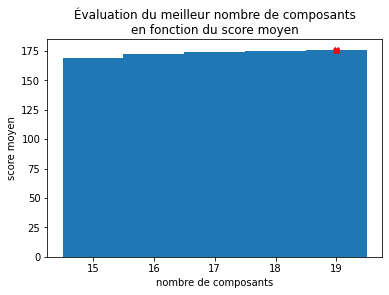

In [57]:
s3_best_nb_comp = get_best_np_comp(s3_comp_ranker, s3_nb_comp_range)

## 4. Conclusion

In [58]:
best_nb_comp = s3_best_nb_comp
pre_proc = sklearn.decomposition.PCA(n_components=best_nb_comp)
pre_proc.fit(X)

X_train_transformed = pre_proc.transform(X_train)
X_valid_transformed = pre_proc.transform(X_valid)
X_test_transformed = pre_proc.transform(X_test)

print(f"Le meilleur nombre de composant pour la PCA : {best_nb_comp}")

Le meilleur nombre de composant pour la PCA : 19


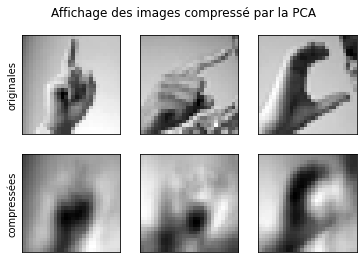

In [59]:
nb_pictures = 3
fig, ax = plt.subplots(2, nb_pictures)

fig.suptitle(f"Affichage des images compressé par la PCA")

for i in range(nb_pictures):
    img = X_train[i].reshape(dim_repre, dim_repre)
    inverse_transformed_img = pre_proc.inverse_transform(X_train_transformed[i])
    compressed_img = inverse_transformed_img.reshape(dim_repre, dim_repre)
    if i == 0:
        ax[0,i].set_ylabel("originales")
        ax[1,i].set_ylabel("compressées")
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    ax[0,i].imshow(img, cm.gray)
    ax[1,i].imshow(compressed_img, cm.gray)

# Modèle
## Sélection du meilleur modèle

In [106]:
model_dict = dict(Svc=SVC(),
                  NuSvc=NuSVC(),
                  DecisionTree=DecisionTreeClassifier())

In [107]:
def analyze_model_experiments(tab_result):
    med_score_validation = tab_result.Score_validation.median()
    med_score_training = tab_result.Score_training.median()
    valid_bad = tab_result.Score_validation < med_score_validation      # On regarde si le score de validation est mauvais 
    train_bad = tab_result.Score_training < med_score_training          # On regarde si le score d'entrainement est mauvais
    overfitted = valid_bad & ~train_bad                                 # Si c'est le cas seulement pour la validation alors on est en overfitting        
    underfitted = valid_bad & train_bad                                 # Si c'est le cas pour les deux alors on est en underfitting
    tab_result['Overfitted'] = overfitted
    tab_result['Underfitted'] = underfitted
    return tab_result

def performance(X_train, Y_train, X_valid, Y_valid, model_dict):
    tab_result = pd.DataFrame(columns=["CVScore",                       # On créé un tableau panda
                                       "(+/-)",
                                       "Score_training",
                                       "Score_validation"])  
    for model_name, model in model_dict.items():                        # On itère sur chaque modèle du dictionnaire
        print(f"Calcul des scores pour le modèle {model_name} ...")
        print("\t- Entrainement du modèle avec l'ensemble d'entrainement")
        model.fit(X_train, Y_train)                                     # On entraine le modèle sur l'ensemble d'entrainement
        print("\t- Calcul du score de validation croisée")
        CVScore = cross_val_score(model, X_train, Y_train, cv=5)        # On calcul la cross validation
        print("\t- Calcul du score sur l'ensemble d'entrainement")
        train_score = model.score(X_train, Y_train)                     # On calcul le score sur l'ensemble d'entrainement
        print("\t- Calcul du score sur l'ensemble de validation")
        valid_score = model.score(X_valid, Y_valid)                     # On calcul le score sur l'ensemble de validation
        print(f"... Fin des calculs pour le modèle {model_name}")
        tab_result.loc[model_name] = np.array([CVScore.mean(),          # On ajoute les scores dans le tableau
                                               CVScore.std() * 2,
                                               train_score,
                                               valid_score])
    return tab_result

In [108]:
compar_results = performance(X_train_transformed,                       # Appel de la fonction "performance" avec nos données transformées
                             y_train,
                             X_valid_transformed,
                             y_valid,
                             model_dict)
compar_results.round(6).style.background_gradient(cmap='Blues')
best_model = compar_results.Score_validation.idxmax()                   # On cherche ici le nom du meilleur modèle

Calcul des scores pour le modèle Svc ...
     -> Entrainement du modèle avec l'ensemble d'entrainement
     -> Calcul du score de validation croisée
     -> Calcul du score sur l'ensemble d'entrainement
     -> Calcul du score sur l'ensemble de validation
... Fin des calculs pour le modèle Svc
Calcul des scores pour le modèle NuSvc ...
     -> Entrainement du modèle avec l'ensemble d'entrainement
     -> Calcul du score de validation croisée
     -> Calcul du score sur l'ensemble d'entrainement
     -> Calcul du score sur l'ensemble de validation
... Fin des calculs pour le modèle NuSvc
Calcul des scores pour le modèle DecisionTree ...
     -> Entrainement du modèle avec l'ensemble d'entrainement
     -> Calcul du score de validation croisée
     -> Calcul du score sur l'ensemble d'entrainement
     -> Calcul du score sur l'ensemble de validation
... Fin des calculs pour le modèle DecisionTree


In [109]:
print("Le meilleur modèle est : {}".format(best_model))

analyze_model_experiments(compar_results)                               # On affiche le tableau des résultats

Le meilleur modèle est : Svc


,CVScore,(+/-),Score_training,Score_validation,Overfitted,Underfitted
Svc,0.94833,0.005859,0.967843,0.964789,False,False
NuSvc,0.81304,0.012311,0.829743,0.817023,False,True
DecisionTree,0.92913,0.012906,1.000000,0.942569,False,False


## Sélection des hyper-paramètres

In [134]:
svc = SVC(kernel='poly')                                                # On initialise notre meilleur modèle
distributions = dict(degree=[2, 3, 4],                                     # On créé un dictionnaire d'hyper-paramètres de ce modèle
                     coef0=[0.0, 1.0, 2.0])
clf = GridSearchCV(svc, distributions)                                  # On apelle RandomeSearchCV qui va nous renvoyer le modèle avec les hyper-paramètres les plus optimisé
search = clf.fit(X_train_transformed, y_train)                          # On entraine notre modèle avec l'ensemble d'entrainement



# print("Score sur l'ensemble de validation : ",                          # On affiche le score obtenu avec l'ensemble de validation
#       search.score(X_valid_transformed, y_valid))     
# print("Meilleurs parametres : ", search.best_params_)                   # On affiche les meilleurs hyper-paramètres
# print("Meilleure configuration : ", search.best_estimator_)             # On affiche la configuration du modèle optimale

{'mean_fit_time': array([ 7.77176042,  7.715557  , 10.48180561,  4.00312395,  3.49747229,
        3.29586234,  3.84841652,  3.30068765,  3.27610011]), 'std_fit_time': array([0.48655261, 0.04929961, 0.1830338 , 0.09754185, 0.04213285,
       0.09452509, 0.11219169, 0.03768709, 0.24612612]), 'mean_score_time': array([2.99640594, 2.81023273, 3.07275825, 2.30419583, 1.67093925,
       1.40125861, 2.08352604, 1.3410707 , 1.02692509]), 'std_score_time': array([0.05614606, 0.08272065, 0.05091281, 0.04726423, 0.0442728 ,
       0.03086584, 0.05551411, 0.09536575, 0.02833389]), 'param_coef0': masked_array(data=[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_degree': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
    

In [140]:
print(pd.DataFrame(search.cv_results_.items()))

                    0                                                  1
0       mean_fit_time  [7.771760416030884, 7.715557003021241, 10.4818...
1        std_fit_time  [0.4865526067761075, 0.04929961064153651, 0.18...
2     mean_score_time  [2.9964059352874757, 2.810232734680176, 3.0727...
3      std_score_time  [0.05614606114117336, 0.08272065046736907, 0.0...
4         param_coef0      [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0]
5        param_degree                        [2, 3, 4, 2, 3, 4, 2, 3, 4]
6              params  [{'coef0': 0.0, 'degree': 2}, {'coef0': 0.0, '...
7   split0_test_score  [0.9170135275754423, 0.867585848074922, 0.7489...
8   split1_test_score  [0.9128511966701353, 0.8668054110301769, 0.740...
9   split2_test_score  [0.9162330905306972, 0.8753902185223725, 0.772...
10  split3_test_score  [0.9138693728857663, 0.8735362997658079, 0.763...
11  split4_test_score  [0.9234972677595629, 0.87848035389019, 0.75279...
12    mean_test_score  [0.9166928910843207, 0.87235

In [154]:
# search.cv_results_.pop("std_fit_time")
# search.cv_results_.pop("mean_score_time")
# search.cv_results_.pop("std_score_time")
for k in search.cv_results_.keys():
    print(k, search.cv_results_[k])

param_coef0 [0.0 0.0 0.0 1.0 1.0 1.0 2.0 2.0 2.0]
param_degree [2 3 4 2 3 4 2 3 4]
params [{'coef0': 0.0, 'degree': 2}, {'coef0': 0.0, 'degree': 3}, {'coef0': 0.0, 'degree': 4}, {'coef0': 1.0, 'degree': 2}, {'coef0': 1.0, 'degree': 3}, {'coef0': 1.0, 'degree': 4}, {'coef0': 2.0, 'degree': 2}, {'coef0': 2.0, 'degree': 3}, {'coef0': 2.0, 'degree': 4}]
split0_test_score [0.91701353 0.86758585 0.74895942 0.95395421 0.98361082 0.99297607
 0.95811655 0.99323621 0.99817898]
split1_test_score [0.9128512  0.86680541 0.74037461 0.95395421 0.9880333  0.99609781
 0.95525494 0.99505723 0.99921956]
split2_test_score [0.91623309 0.87539022 0.77263267 0.95577523 0.98335068 0.99349636
 0.95993757 0.99141519 0.99921956]
split3_test_score [0.91386937 0.8735363  0.76346604 0.95472287 0.98516784 0.99661723
 0.95940671 0.99323445 0.99869893]
split4_test_score [0.92349727 0.87848035 0.75279729 0.95940671 0.98620869 0.99505595
 0.96252927 0.99479573 0.99843872]
mean_test_score [0.91669289 0.87235963 0.7556460

# Test final

In [188]:
selected_label_idx = 5                                                  # on choisi d'afficher différentes représentations d'une lettre
selected_letter = chr(ord('A') + selected_label_idx)                    # la lettre selectionnée
only_A = (selected_label_idx == y_test)                                 # on créé un mask qui filtre les données qui représente notre lettre sélectionnée
X_of_A = X_test[only_A]                                                 # on applique notre masque
print(f'Nous avons trouvés {X_of_A.shape[0]} représentations de la lettre {selected_letter}.')


Nous avons trouvés 247 représentations de la lettre F.


(0.9998194062260984,
 10.933170440755497,
 array([[  0],
        [ 44],
        [ 52],
        [ 94],
        [110]]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


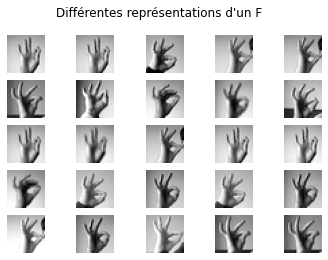

In [162]:
nb_subplots_by_ax = 5
fig, ax = plt.subplots(nb_subplots_by_ax, nb_subplots_by_ax)            # creation des subplots

fig.suptitle(f'Différentes représentations d\'un {selected_letter}')
for i in range(nb_subplots_by_ax):
    for j in range(nb_subplots_by_ax):
        idx = i*nb_subplots_by_ax + j                                   # on transforme le couple (i,j) en l'indice de l'image
        print(idx)
        img = X_of_A[idx].reshape(dim_repre, dim_repre)                 # transformation de la matrice linéaire en matrice carré
        ax[i,j].set_axis_off()                                          # on cache les axes
        ax[i,j].imshow(img, cm.gray)                                    # on affiche l'image sous la forme de nuance de gris

In [132]:
X_transformed = pre_proc.transform(X)

svc = SVC(kernel='poly', coef0=2.0, degree=3)
svc.fit(X_transformed, y)
print("Score final sur l'ensemble test : ", svc.score(X_test_transformed, y_test))